# Testing custom geometry

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics


2023-02-22 09:23:27.378134: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
Start,End = 19,20
for i in range(Start,End):
    i1,i2=str(i),str(i+1)
    if i < 18:
        V2 = '_V2'
    else:
        V2 = ''
    root_url = f"Data/CA-DBB_HH_20{i1}01010000_20{i2}01010000{V2}.csv"
    df = pd.read_csv(root_url,parse_dates=['TIMESTAMP_START'],na_values=-9999)
    df = df.set_index('TIMESTAMP_START')
    if i == Start:
        Data = df.copy()
    else:
        Data = pd.concat(
            [Data,df]
        )


print(Data.columns)
Data[['CO2', 'FC', 'FCH4', 'RH', 'TA', 'NETRAD', 'SW_IN', 'LW_OUT', 
    'P', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',
       ]].describe()
# print(Data.loc[Data['USTAR']>.1,['FC','USTAR']].dropna().describe())
# Data[['FC','USTAR']].dropna().describe()

Index(['TIMESTAMP_END', 'CO2', 'FC', 'FCH4', 'G', 'H', 'LE', 'WD', 'WS',
       'USTAR', 'PA', 'RH', 'TA', 'NETRAD', 'SW_IN', 'SW_OUT', 'LW_IN',
       'LW_OUT', 'P', 'T_SONIC', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1', 'WTD',
       'FC_F', 'H_F', 'LE_F'],
      dtype='object')


,CO2,FC,FCH4,RH,TA,NETRAD,SW_IN,LW_OUT,P,TS_1_1_1,TS_1_2_1,TS_1_3_1,WTD
count,14039.000000,8493.000000,7239.000000,17268.000000,17268.000000,17268.000000,17268.000000,17268.000000,17268.000000,17268.000000,17268.000000,17268.000000,17266.000000
mean,454.487387,-0.511088,53.130978,84.119646,10.332231,83.654380,145.083669,368.230144,0.055606,11.283180,11.170533,11.181859,-0.034991
std,48.592794,2.082539,58.221788,16.513776,6.973685,178.582857,231.463296,43.781101,0.247340,5.215194,5.039984,3.650434,0.087304
min,208.022000,-19.972800,-198.982000,23.498459,-11.491303,-100.376210,0.000000,256.399170,0.000000,2.198570,2.440703,5.170419,-0.237135
25%,422.891500,-1.851350,11.900000,74.369538,5.122254,-21.335570,0.000000,335.465973,0.000000,5.973935,5.934348,7.438402,-0.101637
50%,441.391000,-0.110481,41.100000,90.126430,10.393572,-1.018487,4.072523,363.184738,0.000000,11.294968,10.936223,10.997441,-0.002900
75%,469.720000,0.730473,89.600000,97.618286,15.348335,131.113751,209.299454,393.417503,0.000000,16.602262,16.405610,14.876603,0.037111
max,832.821000,15.514300,656.076000,100.000000,32.197998,805.619896,990.095398,508.935059,5.200000,19.299717,18.582655,16.246504,0.119653


In [5]:
def Calc_VPD(TA, RH):
    # Calculate vapour pressure (hPa)
    # From TA (in celsius) and RH %
    ea_H = 0.61365*np.exp((17.502*TA)/(240.97+TA))
    e_H = RH*ea_H/100
    VPD = ea_H - e_H
    VPD = np.round(VPD*10,5)     # Limit precision
    return (VPD)


Training_Data = Data[['FC','TS_1_1_1','TS_1_2_1','WTD','SW_IN','RH','TA']].dropna()

Training_Data['Month'] = Training_Data.index.month
Training_Data['DOY'] = Training_Data.index.dayofyear
Training_Data['HR'] = Training_Data.index.hour
Training_Data['VPD'] = Calc_VPD(Training_Data['TA'],Training_Data['RH'])

x_train_GPP = Training_Data[['SW_IN','Month']].values
x_train_ER = Training_Data[['TS_1_1_1','Month']].values
y_train_NEE = Training_Data[['FC']].values

print(y_train_NEE.shape)
Training_Data.describe()

(8437, 1)


,FC,TS_1_1_1,TS_1_2_1,WTD,SW_IN,RH,TA,Month,DOY,HR,VPD
count,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000,8437.000000
mean,-0.514839,13.050172,12.876115,-0.053796,239.105200,77.265027,13.337697,6.025127,167.085338,11.796729,4.223267
std,2.084718,4.703004,4.564224,0.085849,274.852350,17.228503,6.739351,2.668385,81.017731,6.162898,4.129768
min,-19.972800,2.489728,2.550641,-0.237135,0.000000,23.498459,-8.446045,1.000000,8.000000,0.000000,0.000000
25%,-1.854690,10.133068,9.932562,-0.109855,0.006384,65.788673,9.282069,4.000000,104.000000,7.000000,1.030910
50%,-0.123596,15.152418,15.019917,-0.031782,119.093719,79.803894,14.051153,6.000000,167.000000,12.000000,3.079850
75%,0.729111,16.998985,16.754539,0.025989,443.875763,91.917671,18.075058,8.000000,233.000000,16.000000,6.183980
max,15.514300,19.271887,18.582655,0.065817,990.095398,100.000000,31.221455,11.000000,333.000000,23.000000,31.919210


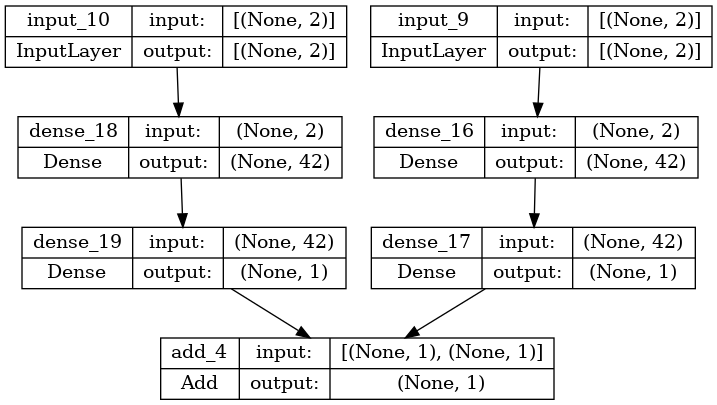

In [20]:
def make_model(GPP_shape,ER_shape,hidden_nodes):
    input_layer_GPP = keras.layers.Input(GPP_shape)
    GPP = keras.layers.Dense(
                            hidden_nodes,
                            activation='relu',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros",
                            )(input_layer_GPP)
                            
    GPP_out = keras.layers.Dense(
                            1,
                            )(GPP)
                                
    input_layer_ER = keras.layers.Input(ER_shape)
    ER = keras.layers.Dense(
                            hidden_nodes,
                            activation='relu',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros",
                            )(input_layer_ER)

    # ER_out = keras.backend.abs(
    #                 keras.layers.Dense(
    #                         1,
    #                         )(ER)
    #                             )
                                
    ER_out = keras.layers.Dense(
                            1,
                            )(ER)

    NEE = keras.layers.Add()([ER_out, GPP_out])


    return keras.models.Model(inputs=[input_layer_GPP,input_layer_ER], outputs=NEE)


model = make_model(x_train_GPP.shape[1],
                    x_train_ER.shape[1],
                    42)
# model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [21]:
epochs = 250
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "temp_files/Custom_Model/best_model.h5", save_best_only=True, monitor="val_loss", verbose=1
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

history = model.fit(
    [x_train_GPP,x_train_ER],
    y_train_NEE,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

Epoch 1/250
205/211 [============================>.] - ETA: 0s - loss: 98.2290 
Epoch 1: val_loss improved from inf to 2.92793, saving model to temp_files/Custom_Model/best_model.h5
211/211 [==============================] - 2s 8ms/step - loss: 95.5481 - val_loss: 2.9279 - lr: 0.0010
Epoch 2/250
205/211 [============================>.] - ETA: 0s - loss: 2.5575
Epoch 2: val_loss improved from 2.92793 to 2.66164, saving model to temp_files/Custom_Model/best_model.h5
211/211 [==============================] - 1s 7ms/step - loss: 2.5399 - val_loss: 2.6616 - lr: 0.0010
Epoch 3/250
208/211 [============================>.] - ETA: 0s - loss: 2.3177
Epoch 3: val_loss improved from 2.66164 to 2.52496, saving model to temp_files/Custom_Model/best_model.h5
211/211 [==============================] - 1s 7ms/step - loss: 2.3606 - val_loss: 2.5250 - lr: 0.0010
Epoch 4/250
207/211 [============================>.] - ETA: 0s - loss: 2.2717
Epoch 4: val_loss did not improve from 2.52496
211/211 [=========

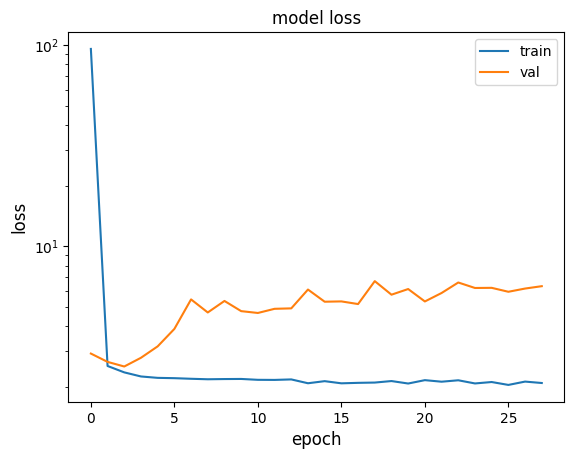

264/264 [==============================] - 1s 4ms/step
0.4761069687374253
1.50883899655967


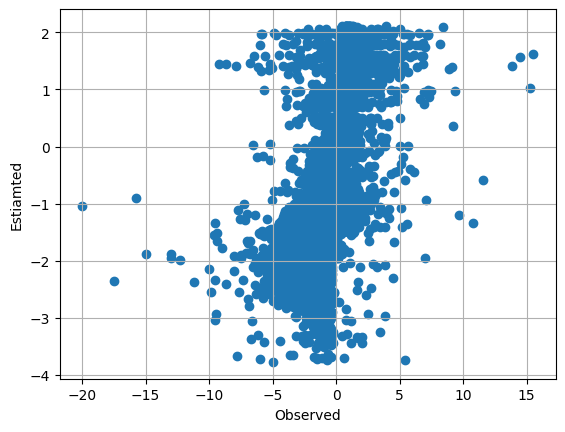

In [22]:
model = keras.models.load_model("temp_files/Custom_Model/best_model.h5")

# test_loss = model.evaluate([x_train_GPP,x_train_ER], y_train_NEE)
# print("Test loss", test_loss)
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')
plt.show()
plt.close()

pred = model.predict([x_train_GPP,x_train_ER])

fig,ax=plt.subplots()
ax.scatter(y_train_NEE,pred)
ax.set_ylabel('Estiamted')
ax.set_xlabel('Observed')
# ax.set_ylim(ax.get_xlim())
ax.grid()
print(metrics.r2_score(y_train_NEE,pred))
print(metrics.mean_squared_error(y_train_NEE,pred)**.5)

(2, 42)
(42,)
(2, 42)
(42,)
(42, 1)
(1,)
(42, 1)
(1,)
8


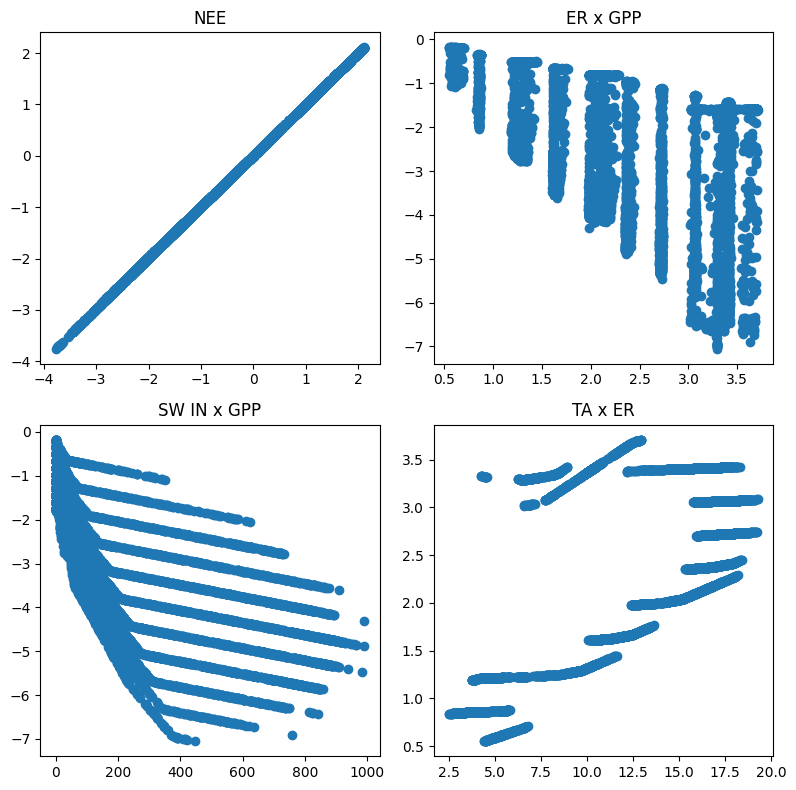

In [23]:
W = model.get_weights()
for w in W:
    print(w.shape)
print(len(W))

W_i_ER = (W[0])
W_i_ER_T = (W[0].T)

W_i_GPP = (W[2])
W_i_GPP_T = (W[2].T)

W_d_i_ER = (W[1])
W_d_i_GPP = (W[3])

W_d_o_ER = (W[4])
W_d_o_ER_T = (W[4].T)

W_d_o_GPP = (W[6])
W_d_o_GPP_T = (W[6].T)

W_o_ER = (W[5])
W_o_GPP = (W[7])

# w_do_i = (W[8])
# w_do_o = (W[9])


Op_GPP = []
for i in range(y_train_NEE.shape[0]):
    Ip_GPP = x_train_GPP[i]
    H1_GPP = (Ip_GPP*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
    # First derivative of the relu function
    # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
    H1_GPP = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
    H2_GPP = (H1_GPP*W_d_o_GPP_T).sum(axis=-1)+W_o_GPP
    # H2_GPP = np.maximum(H2_GPP,np.zeros(H2_GPP.shape))
    Op_GPP.append(H2_GPP)# - .diagonal()  needed if doing multiple models at onece 
Estimates_GPP = np.array(Op_GPP)


Op_ER = []
for i in range(y_train_NEE.shape[0]):
    Ip_ER = x_train_ER[i]
    H1_ER = (Ip_ER*W_i_ER_T).sum(axis=-1)+W_d_i_ER
    # First derivative of the relu function
    # If using Sigmoid function, change to - H1 = 1/(1+np.exp(-H1))
    H1_ER = np.maximum(H1_ER,np.zeros(H1_ER.shape))
    H2_ER = (H1_ER*W_d_o_ER_T).sum(axis=-1)+W_o_ER
    # H2_ER = np.maximum(H2_ER,np.zeros(H2_ER.shape))
    Op_ER.append(H2_ER)# - .diagonal()  needed if doing multiple models at onece 
Estimates_ER = np.array(Op_ER)

Estimates_NEE = Estimates_ER+Estimates_GPP

# Estimates_NEE = (Estimates_NEE*w_do_i).sum(axis=-1)+w_do_o

fig,axes=plt.subplots(2,2,figsize=(8,8))
ax = axes[0,0]
ax.scatter(pred,Estimates_NEE)
ax.set_title('NEE')

ax = axes[0,1]
ax.scatter(Estimates_ER,Estimates_GPP)
ax.set_title('ER x GPP')

ax = axes[1,0]
ax.scatter(x_train_GPP[:,0],Estimates_GPP)
ax.set_title('SW IN x GPP')

ax = axes[1,1]
ax.scatter(x_train_ER[:,0],Estimates_ER)
ax.set_title('TA x ER')

plt.tight_layout()

In [24]:
SSD = []
SAD = []
Derivs = []
# print(W_d_o_GPP.shape)
for i in range(x_train_GPP.shape[1]):
    dj_GPP=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_GPP[j][i]
        if np.isnan(target)==False:
            H1_GPP = (Xj*W_i_GPP_T).sum(axis=-1)+W_d_i_GPP
            AD = np.maximum(H1_GPP,np.zeros(H1_GPP.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_GPP[h]*W_i_GPP[i,h] for h in range(W_d_o_GPP.shape[0])]).sum(axis=0)
            # print(Sum)
            # print(AD.shape,W_d_o_GPP.shape,W_i_GPP[i].shape)
            Sum = (AD*W_d_o_GPP[:,0]*W_i_GPP[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_GPP.append(Sj*Sum)
    dji_GPP = np.array(dj_GPP)#*w_do_i
    print(dji_GPP.shape)
    Derivs.append(dji_GPP)



for i in range(x_train_ER.shape[1]):
    dj_ER=[]
    for j in range(y_train_NEE.shape[0]):
        target = y_train_NEE[j]
        Xj = x_train_ER[j][i]
        if np.isnan(target)==False:
            H1_ER = (Xj*W_i_ER_T).sum(axis=-1)+W_d_i_ER
            AD = np.maximum(H1_ER,np.zeros(H1_ER.shape))
            AD[AD>0]=1
            # Sum = np.array([AD[h]*W_d_o_ER[h]*W_i_ER[i,h] for h in range(W_d_o_ER.shape[0])]).sum(axis=0)
            Sum = (AD*W_d_o_ER[:,0]*W_i_ER[i]).sum(axis=0)
            # print(Sum)
            Sj = 1
            dj_ER.append(Sj*Sum)
    # print(dj_GPP.mean())
    dji_ER = np.array(dj_ER)#*w_do_i
    print(dji_ER.shape)
    Derivs.append(dji_ER)

#     SSD.append(np.sum(dji**2,axis=0))
#     SAD.append(np.sum(np.abs(dji),axis=0))
# Derivs = np.array(Derivs)
# SSD = np.array(SSD)
# RI_SSD = SSD/SSD.sum(axis=0)
# SAD = np.array(SAD)
# RI_SAD = SAD/SAD.sum(axis=0)

(8437,)
(8437,)
(8437,)
(8437,)


(8437,)

(8437,)

(8437,)

(8437,)



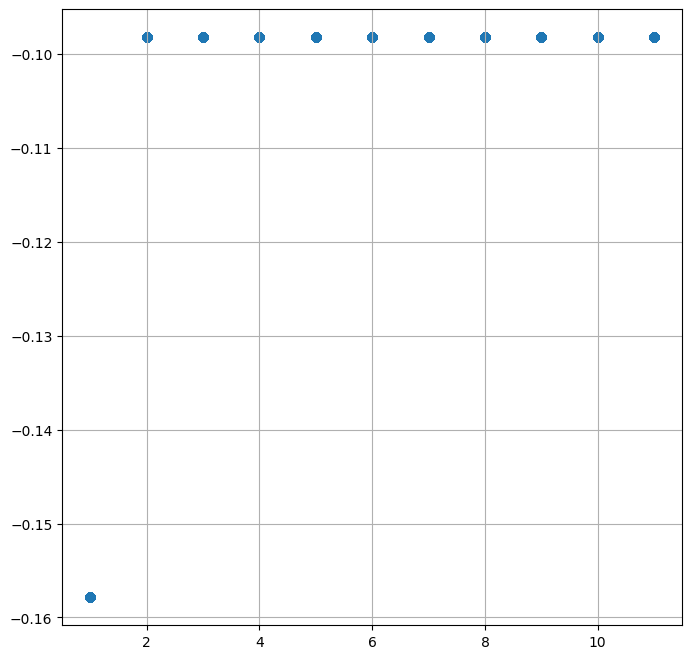

In [30]:

for d in Derivs:
    
    print(d.shape)
    print()
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_train_GPP[:,1],Derivs[1])
# ax.set_xlim(-1,1)
ax.grid()